# Gmail vs Calendar Query Classifier using BERT
# -----------------------------------------------------------
# This notebook builds a text classification model using BERT to differentiate between Gmail-related and Calendar-related queries.
# It includes model training, evaluation, date extraction, and a Streamlit interface.

In [7]:
# STEP 1: Install dependencies
!pip install transformers datasets scikit-learn torch --quiet
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------------------ --------------------- 6.0/12.8 MB 30.7 MB/s eta 0:00:01
     ---------------------------------- ---- 11.3/12.8 MB 28.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 23.6 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
# STEP 2: Import necessary libraries
import os
os.environ["USE_TF"] = "0"  # Disable TensorFlow in Transformers to avoid tf_keras issue
import pandas as pd
import torch
import spacy
import re
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [18]:
def build_dataset():
    raw_data = [
        # -------- Gmail Queries (30) --------
        ("Find emails with PDF attachments", "gmail"),
        ("Show me unread messages in my inbox", "gmail"),
        ("Search for emails from Sarah about the project proposal", "gmail"),
        ("Find messages with the label 'Urgent'", "gmail"),
        ("What are the latest emails from HR?", "gmail"),
        ("Get emails that mention 'meeting notes'", "gmail"),
        ("Retrieve my conversation with Alex about the trip", "gmail"),
        ("Check if I got any emails with invoices", "gmail"),
        ("What did Sarah say in the email about budget?", "gmail"),
        ("Emails flagged as important", "gmail"),
        ("Do I have any mail from John regarding the party?", "gmail"),
        ("Show all messages from last week", "gmail"),
        ("Look for emails with attachments from Ravi", "gmail"),
        ("Get all flagged emails", "gmail"),
        ("Do I have any emails with the subject 'deadline'?", "gmail"),
        ("Show me starred conversations", "gmail"),
        ("Find my conversation with support team", "gmail"),
        ("Locate emails I sent yesterday", "gmail"),
        ("Any emails marked confidential?", "gmail"),
        ("Which emails did I archive last?", "gmail"),
        ("Filter emails that contain the word 'invoice'", "gmail"),
        ("Open the email thread about internship", "gmail"),
        ("Get messages from admin regarding schedule", "gmail"),
        ("Look up the latest messages with PDF attachments", "gmail"),
        ("Get unread emails from last weekend", "gmail"),
        ("Emails that mention calendar invites", "gmail"),
        ("Show emails from finance department", "gmail"),
        ("Was there any email from my professor?", "gmail"),
        ("Find emails that discuss meeting timings", "gmail"),
        ("Show messages I received about registration", "gmail"),

        # -------- Calendar Queries (30) --------
        ("When is my next meeting with the design team?", "calendar"),
        ("Find appointments with Dr. Johnson", "calendar"),
        ("Show me all-day events in May", "calendar"),
        ("When is the team lunch scheduled for?", "calendar"),
        ("Add a meeting with Rahul tomorrow at 3 PM", "calendar"),
        ("Check my schedule for next week", "calendar"),
        ("Do I have any events on the weekend?", "calendar"),
        ("List all recurring events", "calendar"),
        ("Find my meetings for June 2025", "calendar"),
        ("What is on my calendar today?", "calendar"),
        ("Am I free on Friday after 5 PM?", "calendar"),
        ("Schedule a doctor appointment on Tuesday", "calendar"),
        ("Add internship interview to my calendar", "calendar"),
        ("Remind me of monthly review call", "calendar"),
        ("Calendar for October travel plans", "calendar"),
        ("Plan all events for next quarter", "calendar"),
        ("Do I have a client call this afternoon?", "calendar"),
        ("Show all my meetings for the upcoming week", "calendar"),
        ("What’s planned in my calendar tomorrow?", "calendar"),
        ("Are there any events overlapping on Wednesday?", "calendar"),
        ("Get me the agenda for next Friday’s calendar", "calendar"),
        ("Do I have any one-on-ones this month?", "calendar"),
        ("Show my calendar entries tagged 'important'", "calendar"),
        ("Block time for deep work next Thursday", "calendar"),
        ("Reschedule my product demo to Tuesday", "calendar"),
        ("List meetings scheduled with the marketing team", "calendar"),
        ("Check if I'm double-booked tomorrow", "calendar"),
        ("Remind me about the meeting with Sarah", "calendar"),
        ("Search my calendar for budget discussions", "calendar"),
        ("Was there an event scheduled after the last email?", "calendar"),
    ]
    df = pd.DataFrame(raw_data, columns=["query", "label"])
    df['label'] = df['label'].map({'gmail': 0, 'calendar': 1})
    return df

df = build_dataset()

In [19]:
# STEP 3: Define Dataset Wrapper Class
import torch
class QueryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [20]:
# STEP 4: Define Training and Evaluation Logic
def train_eval_model(model_name, tokenizer, train_idx, val_idx, df):
    train_texts = df.iloc[train_idx]['query'].tolist()
    train_labels = df.iloc[train_idx]['label'].tolist()
    val_texts = df.iloc[val_idx]['query'].tolist()
    val_labels = df.iloc[val_idx]['label'].tolist()

    train_encodings = tokenizer(train_texts, truncation=True, padding=True)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)

    train_dataset = QueryDataset(train_encodings, train_labels)
    val_dataset = QueryDataset(val_encodings, val_labels)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    model.to(device)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]).to(device))

    # Training loop
    model.train()
    for epoch in range(3):
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Training Loss = {total_loss/len(train_loader):.4f}")

    # Evaluation
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='d', xticklabels=["Gmail", "Calendar"], yticklabels=["Gmail", "Calendar"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return model

C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD ht


=== Fold 1 ===


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Training Loss = 0.7029
Epoch 2: Training Loss = 0.6740
Epoch 3: Training Loss = 0.5037
Accuracy: 1.0
F1 Score: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



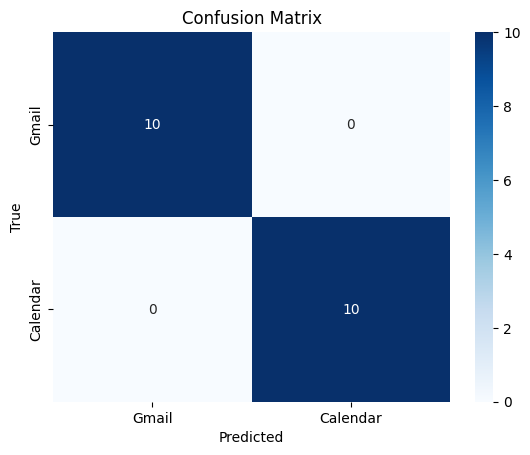

C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].



=== Fold 2 ===


HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Training Loss = 0.6852
Epoch 2: Training Loss = 0.6449
Epoch 3: Training Loss = 0.4141
Accuracy: 0.95
F1 Score: 0.949874686716792
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



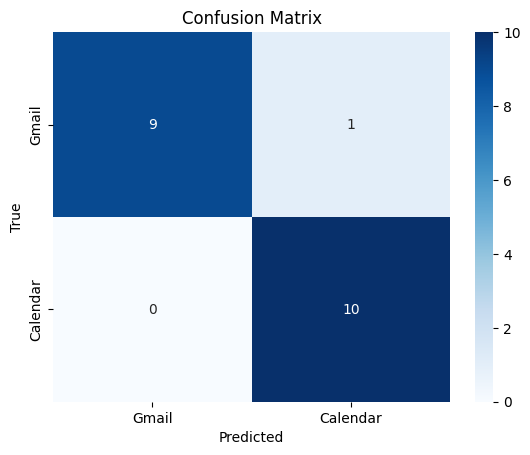


=== Fold 3 ===


C:\Users\antil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolve/main/config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/roberta-base/resolv

Epoch 1: Training Loss = 0.6846
Epoch 2: Training Loss = 0.6678
Epoch 3: Training Loss = 0.3698
Accuracy: 0.95
F1 Score: 0.949874686716792
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



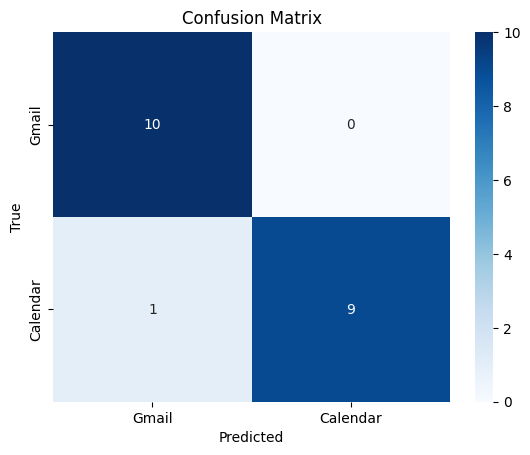

In [21]:
# STEP 5: Stratified K-Fold Validation
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import StratifiedKFold
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

final_model = None
for fold, (train_idx, val_idx) in enumerate(skf.split(df['query'], df['label'])):
    print(f"\n=== Fold {fold+1} ===")
    final_model = train_eval_model(model_name, tokenizer, train_idx, val_idx, df)

In [22]:
# Save model and tokenizer correctly
final_model.save_pretrained("saved_model")    
tokenizer.save_pretrained("saved_tokenizer")
print("\n✅ Model and tokenizer saved successfully for Streamlit deployment.")


✅ Model and tokenizer saved successfully for Streamlit deployment.
